# Wine Quality: Wine and Alcohol

Wine = White Wine

What's it with wine and alcohol? What is the role of alcohol in wine taste / quality?
- Do all good wines have a high alcohol content?
  - Of course not!
  - How to find the secondary quantities? Have a look at the patterns
- Is there good wine with low alcohol? What does that mean?
  - There are also many other factors that impact wine quality.
  - Some are in the data set: parameters that affect taste and consistency
  - Some are not in the data set: parameters that affect smell
- Which other parameters are causally linked to alcohol?
- Which other quantities correlate with alcohol?
  - density
  - total sulfur oxide (neg, high)
  - chlorides (neg, high)
  - free sulfur oxide (neg, high)
  - residual sugar
  - What could be the reasons for the correlations? Are there causal links?
    - total and free sulfur: less preservatives are needed if alcohol is higher
    - chlorides: may be balanced by alcohol
    - residual sugar: remaining sugar after fermentation
    - density: directly linked to alcohol (more alcohol lowers the density), but it is also influenced by other components, such as tannins, sugar etc.

Do tasters prefer wine with a high alcohol content?
Hypothesis: With the complexity of the matter, it's hard to say! It's just an indicator for a good wine
How strong is this indicator? 

Are all wine tasters alcoholics? 

# Goal
- Find 

# Config Notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from scipy import stats 
import pingouin as pg

# import pyarrow as pa

In [3]:
# config packages
pd.options.mode.copy_on_write = "warn"

In [4]:
# load project config
with open("../config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
config

{'data_path_wine_red': 'data/wine+quality/winequality-red.csv',
 'data_path_wine_white': 'data/wine+quality/winequality-white.csv'}

In [5]:
# useful constants
all_inputs = [
    'ph', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
    'chlorides', 
    'total_sulfur_dioxide', 'free_sulfur_dioxide', 'sulphates',
    'residual_sugar',
    'density',
    'alcohol'
    ]

all_columns = [
    'ph', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
    'chlorides', 
    'total_sulfur_dioxide', 'free_sulfur_dioxide', 'sulphates',
    'residual_sugar',
    'density',
    'alcohol',
    'quality'
]

# Import

In [7]:
# NOTE - Keep two data frames if data is actually separate
# TODO - how to build paths in python
# TODO - work with config

# wine data
# wine_r = pd.read_parquet('../' + config['data_path_wine_red'], sep=';')
# wine_w = pd.read_parquet('../' + config['data_path_wine_white'], sep=';')
wine_w = pd.read_parquet('../data/processed/wine_w.parquet')
wine_r = pd.read_parquet('../data/processed/wine_r.parquet')
wine   = pd.read_parquet('../data/processed/wine.parquet')

# normalized wine data
wine_w_norm = pd.read_parquet('../data/processed/wine_w_norm.parquet')
wine_r_norm = pd.read_parquet('../data/processed/wine_r_norm.parquet')
wine_norm = pd.read_parquet('../data/processed/wine_norm.parquet')

In [8]:
wine_w.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3746 entries, 0 to 4897
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ph                    3746 non-null   float64 
 1   fixed_acidity         3746 non-null   float64 
 2   volatile_acidity      3746 non-null   float64 
 3   citric_acid           3746 non-null   float64 
 4   chlorides             3746 non-null   float64 
 5   total_sulfur_dioxide  3746 non-null   float64 
 6   free_sulfur_dioxide   3746 non-null   float64 
 7   sulphates             3746 non-null   float64 
 8   residual_sugar        3746 non-null   float64 
 9   density               3746 non-null   float64 
 10  alcohol               3746 non-null   float64 
 11  quality               3746 non-null   int64   
 12  color                 3746 non-null   category
 13  quality_label         3746 non-null   category
dtypes: category(2), float64(11), int64(1)
memory usage: 388.0 KB


In [9]:
wine_r.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1359 entries, 0 to 1598
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ph                    1359 non-null   float64 
 1   fixed_acidity         1359 non-null   float64 
 2   volatile_acidity      1359 non-null   float64 
 3   citric_acid           1359 non-null   float64 
 4   chlorides             1359 non-null   float64 
 5   total_sulfur_dioxide  1359 non-null   float64 
 6   free_sulfur_dioxide   1359 non-null   float64 
 7   sulphates             1359 non-null   float64 
 8   residual_sugar        1359 non-null   float64 
 9   density               1359 non-null   float64 
 10  alcohol               1359 non-null   float64 
 11  quality               1359 non-null   int64   
 12  color                 1359 non-null   category
 13  quality_label         1359 non-null   category
dtypes: category(2), float64(11), int64(1)
memory usage: 140.9 KB


# Analysis

In [26]:
wine_w[inputs].iloc[0]-wine_w[inputs].iloc[1]

ph                      -0.300
fixed_acidity            0.700
volatile_acidity        -0.030
citric_acid              0.020
chlorides               -0.004
total_sulfur_dioxide    38.000
free_sulfur_dioxide     31.000
sulphates               -0.040
residual_sugar          19.100
density                  0.007
dtype: float64

In [ ]:
def distance_wine_inputs(x,y):
    return abs(x-y).max()

print(distance_wine_inputs(wine_w_norm[inputs].iloc[0], wine_w_norm[inputs].iloc[1]))

0.2929447852760736

In [46]:
# find similar wines
from sklearn.cluster import DBSCAN

# similarity parameters
inputs = [
    'ph', #'fixed_acidity', 'volatile_acidity', 'citric_acid',
    'chlorides',
    'total_sulfur_dioxide', #'free_sulfur_dioxide', 'sulphates',
    'residual_sugar',
    'density'
    ]

# tuning
eps = 0.025
min_samples = 2

# clustering
clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=distance_wine_inputs).fit(wine_w_norm[inputs])

# transfer
wine_w_norm['cluster']  = clustering.labels_
wine_w['cluster']  = clustering.labels_

In [48]:
clusters_counts = wine_w_norm.cluster.value_counts()
clusters_counts

cluster
 1      1566
-1      1158
 2        18
 62       18
 3        17
        ... 
 90        2
 24        2
 94        2
 95        2
 290       2
Name: count, Length: 333, dtype: int64

In [60]:
wine_w_norm[wine_w_norm.cluster == 1].describe()

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality,cluster
count,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1566.000000,1184.000000,1566.0
mean,0.431069,0.287513,0.188607,0.199465,0.093532,0.592729,0.254512,0.317005,0.049993,0.104866,0.470763,5.912162,1.0
std,0.082748,0.072887,0.092898,0.067145,0.024832,0.166948,0.117808,0.131879,0.049400,0.043778,0.192133,0.962028,0.0
min,0.200000,0.096154,0.000000,0.000000,0.014837,0.253731,0.008197,0.046512,0.001534,0.013110,0.064516,3.000000,1.0
25%,0.372727,0.240385,0.127451,0.162651,0.074926,0.462687,0.172131,0.232558,0.012270,0.071477,0.322581,5.000000,1.0
50%,0.427273,0.278846,0.176471,0.192771,0.091988,0.562189,0.237705,0.302326,0.026074,0.096588,0.467742,6.000000,1.0
75%,0.481818,0.326923,0.235294,0.228916,0.112760,0.701493,0.327869,0.383721,0.082822,0.133748,0.618952,7.000000,1.0
max,0.654545,1.000000,1.000000,1.000000,0.175074,1.000000,0.696721,1.000000,0.236963,0.243686,1.000000,9.000000,1.0


In [62]:
wine_w_norm[wine_w_norm.cluster == 1].corr(numeric_only=True)

,ph,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,free_sulfur_dioxide,sulphates,residual_sugar,density,alcohol,quality,cluster
ph,1.000000,-0.362362,-0.036706,-0.096158,-0.099972,-0.130212,-0.092911,0.068595,-0.229267,-0.163371,0.134847,-0.027678,NaN
fixed_acidity,-0.362362,1.000000,-0.020329,0.267127,0.139990,0.135523,-0.012942,-0.022115,0.114713,0.312852,-0.084198,0.012556,NaN
volatile_acidity,-0.036706,-0.020329,1.000000,-0.181562,-0.031817,0.062365,-0.106750,-0.063516,0.135177,0.024336,0.081713,0.058748,NaN
citric_acid,-0.096158,0.267127,-0.181562,1.000000,0.030419,0.119168,0.083430,0.040985,0.125128,0.151667,-0.026153,-0.042540,NaN
chlorides,-0.099972,0.139990,-0.031817,0.030419,1.000000,0.439654,0.162140,-0.024014,0.228118,0.513602,-0.542748,0.056951,NaN
total_sulfur_dioxide,-0.130212,0.135523,0.062365,0.119168,0.439654,1.000000,0.598436,-0.004295,0.582259,0.673857,-0.524777,-0.045893,NaN
free_sulfur_dioxide,-0.092911,-0.012942,-0.106750,0.083430,0.162140,0.598436,1.000000,-0.021541,0.451914,0.365859,-0.263733,-0.035362,NaN
sulphates,0.068595,-0.022115,-0.063516,0.040985,-0.024014,-0.004295,-0.021541,1.000000,-0.053155,0.018249,0.034339,0.007336,NaN
residual_sugar,-0.229267,0.114713,0.135177,0.125128,0.228118,0.582259,0.451914,-0.053155,1.000000,0.764348,-0.406501,-0.028654,NaN
density,-0.163371,0.312852,0.024336,0.151667,0.513602,0.673857,0.365859,0.018249,0.764348,1.000000,-0.826345,-0.031143,NaN


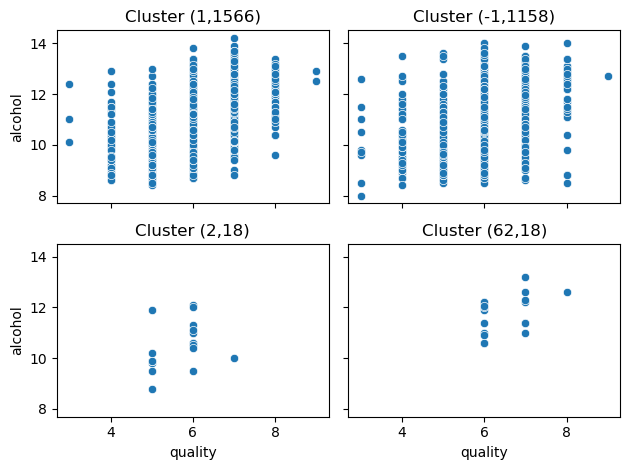

In [ ]:
# scatter plot of alcohol vs quality for the largest clusters
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

ax = ax.flatten()

for a, cluster, cluster_size in zip(ax,clusters_counts[0:4].index,clusters_counts[0:4].values):
    sns.scatterplot(wine_w[wine_w.cluster == cluster], x='quality', y='alcohol', ax=a)
    a.set_title('Cluster ('+str(cluster)+','+str(cluster_size)+')')

plt.tight_layout()

similar wines are hard to find, because the data is quite noisy!
- reduce inputs?
- 